In [1]:
# Transformers installation
#! pip install transformers datasets
# To install from source instead of the last release, comment the command above and uncomment the following one.
# ! pip install git+https://github.com/huggingface/transformers.git

In [2]:
#!pip install transformers evaluate -q
#!pip install jiwer -q

# Image captioning

In [24]:
from datasets import load_dataset

ds = load_dataset("nlphuji/flickr30k")

ds

DatasetDict({
    test: Dataset({
        features: ['image', 'caption', 'sentids', 'split', 'img_id', 'filename'],
        num_rows: 31014
    })
})

In [25]:
ds = ds["test"].train_test_split(test_size=0.1)
train_ds = ds["train"]
test_ds = ds["test"]

In [26]:
test_ds

Dataset({
    features: ['image', 'caption', 'sentids', 'split', 'img_id', 'filename'],
    num_rows: 3102
})

Let's visualize a couple of samples from the training set.

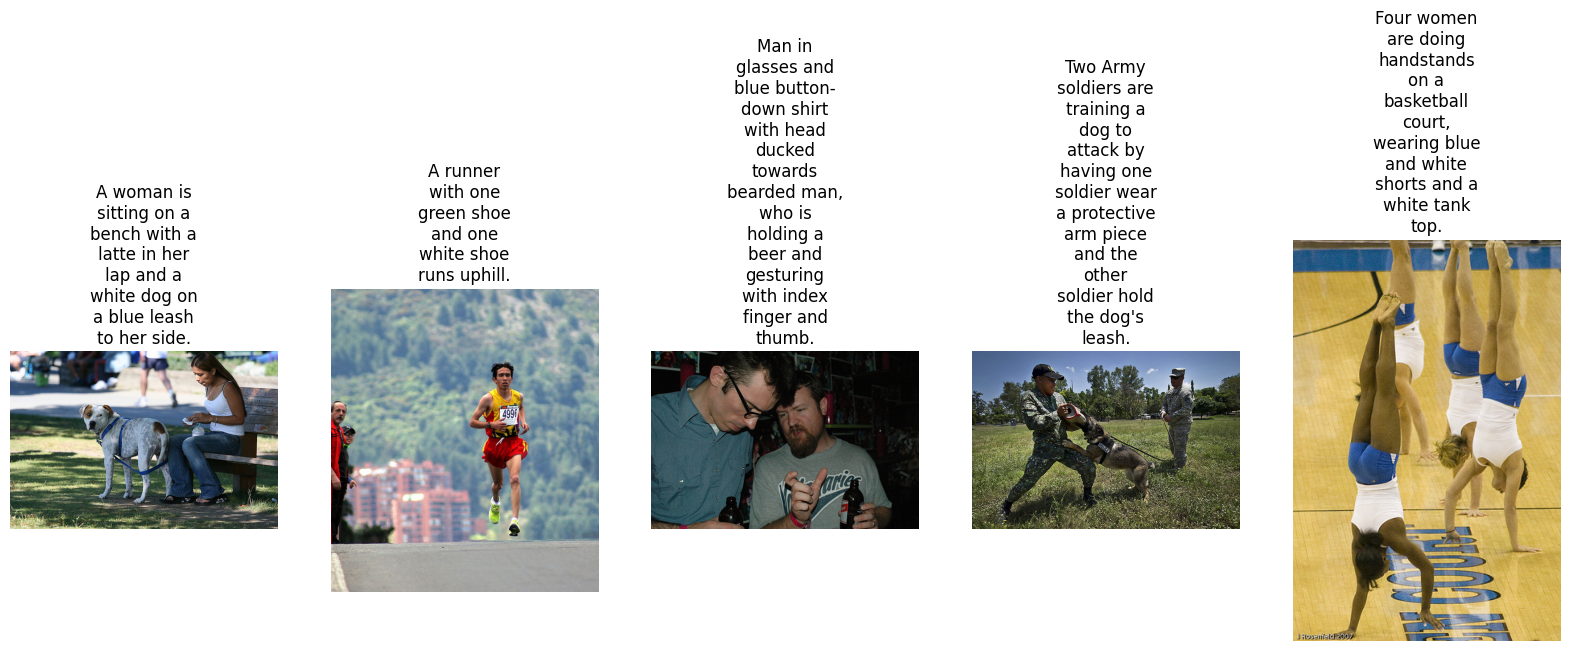

In [6]:
from textwrap import wrap
import matplotlib.pyplot as plt
import numpy as np


def plot_images(images, captions):
    plt.figure(figsize=(20, 20))
    for i in range(len(images)):
        ax = plt.subplot(1, len(images), i + 1)
        caption = captions[i][0]
        caption = "\n".join(wrap(caption, 12))
        plt.title(caption)
        plt.imshow(images[i])
        plt.axis("off")


sample_images_to_visualize = [np.array(train_ds[i]["image"]) for i in range(5)]
sample_captions = [train_ds[i]["caption"] for i in range(5)]
plot_images(sample_images_to_visualize, sample_captions)

## Preprocess the dataset

Since the dataset has two modalities (image and text), the pre-processing pipeline will preprocess images and the captions.

To do so, load the processor class associated with the model you are about to fine-tune.

In [7]:
from transformers import AutoProcessor

checkpoint = "microsoft/git-base"
processor = AutoProcessor.from_pretrained(checkpoint)

The processor will internally pre-process the image (which includes resizing, and pixel scaling) and tokenize the caption.

In [8]:
def transforms(example_batch):
    images = [x for x in example_batch["image"]]
    captions = [x[0] for x in example_batch["caption"]]
    inputs = processor(images=images, text=captions, padding="max_length")
    inputs.update({"labels": inputs["input_ids"]})
    return inputs


train_ds.set_transform(transforms)
test_ds.set_transform(transforms)

## Load a base model

Load the ["microsoft/git-base"](https://huggingface.co/microsoft/git-base) into a [`AutoModelForCausalLM`](https://huggingface.co/docs/transformers/model_doc/auto#transformers.AutoModelForCausalLM) object.

In [9]:
from transformers import AutoModelForCausalLM

model = AutoModelForCausalLM.from_pretrained(checkpoint)

## Evaluate

Image captioning models are typically evaluated with the [Rouge Score](https://huggingface.co/spaces/evaluate-metric/rouge) or [Word Error Rate](https://huggingface.co/spaces/evaluate-metric/wer). For this guide, you will use the Word Error Rate (WER).

We use the 🤗 Evaluate library to do so. For potential limitations and other gotchas of the WER, refer to [this guide](https://huggingface.co/spaces/evaluate-metric/wer).

In [10]:
from evaluate import load
import torch

wer = load("wer")


def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predicted = logits.argmax(-1)
    decoded_labels = processor.batch_decode(labels, skip_special_tokens=True)
    decoded_predictions = processor.batch_decode(predicted, skip_special_tokens=True)
    wer_score = wer.compute(predictions=decoded_predictions, references=decoded_labels)
    return {"wer_score": wer_score}

## Train!

Now, you are ready to start fine-tuning the model. You will use the 🤗 [Trainer](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.Trainer) for this.

First, define the training arguments using [TrainingArguments](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.TrainingArguments).

In [11]:
from transformers import TrainingArguments, Trainer

model_name = checkpoint.split("/")[1]

training_args = TrainingArguments(
    output_dir=f"{model_name}-cv_transformers_flickr30k",
    learning_rate=5e-5,
    num_train_epochs=10,
    fp16=True,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    gradient_accumulation_steps=2,
    save_total_limit=3,
    evaluation_strategy="steps",
    eval_steps=50,
    save_strategy="steps",
    save_steps=50,
    logging_steps=50,
    remove_unused_columns=False,
    push_to_hub=True,
    label_names=["labels"],
    #load_best_model_at_end=True,
)

c:\Users\ALEJANDRO\Documents\7. DUKE\1. ECE 684 - NLP\Assignments\Final Project\venv_lda_implementation\Lib\site-packages\transformers\training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Then pass them along with the datasets and the model to 🤗 Trainer.

In [12]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    compute_metrics=compute_metrics,
)


To start training, simply call [train()](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.Trainer.train) on the [Trainer](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.Trainer) object.

In [12]:
trainer.train()

  0%|          | 0/34890 [00:00<?, ?it/s]

KeyboardInterrupt: 

## Inference

Take a sample image from `test_ds` to test the model.

In [20]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

GitForCausalLM(
  (git): GitModel(
    (embeddings): GitEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(1024, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (image_encoder): GitVisionModel(
      (vision_model): GitVisionTransformer(
        (embeddings): GitVisionEmbeddings(
          (patch_embedding): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16), bias=False)
          (position_embedding): Embedding(197, 768)
        )
        (pre_layrnorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (encoder): GitVisionEncoder(
          (layers): ModuleList(
            (0-11): 12 x GitVisionEncoderLayer(
              (self_attn): GitVisionAttention(
                (k_proj): Linear(in_features=768, out_features=768, bias=True)
                (v_proj): Linear(in_features=768, out_features=768, bias=True)
             

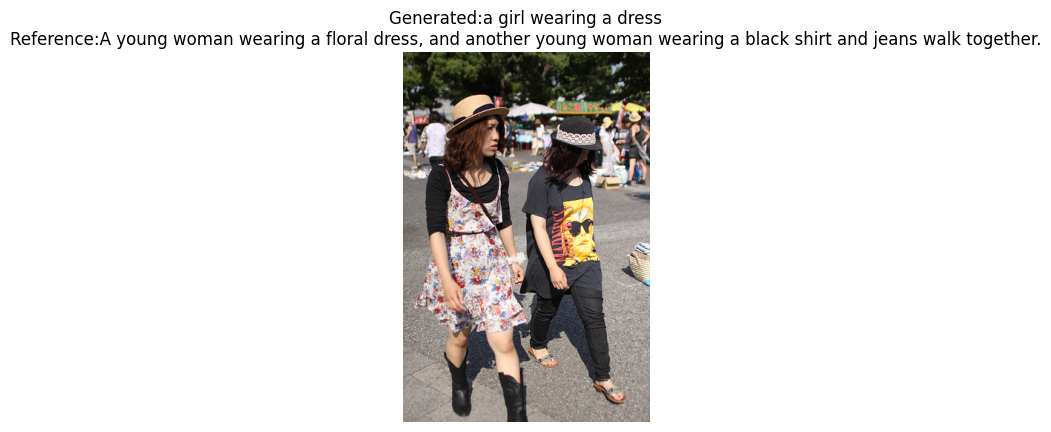

BLEU Score: 0.4639245457849246


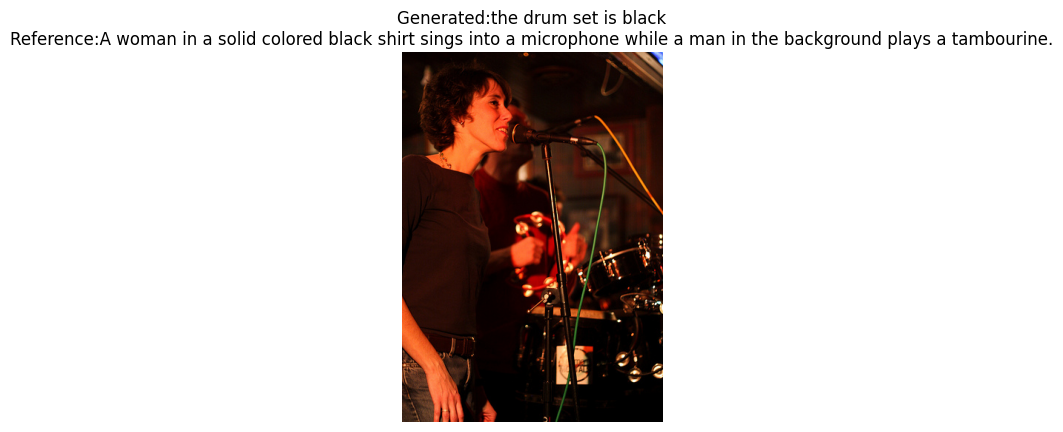

BLEU Score: 0.17837746551119074


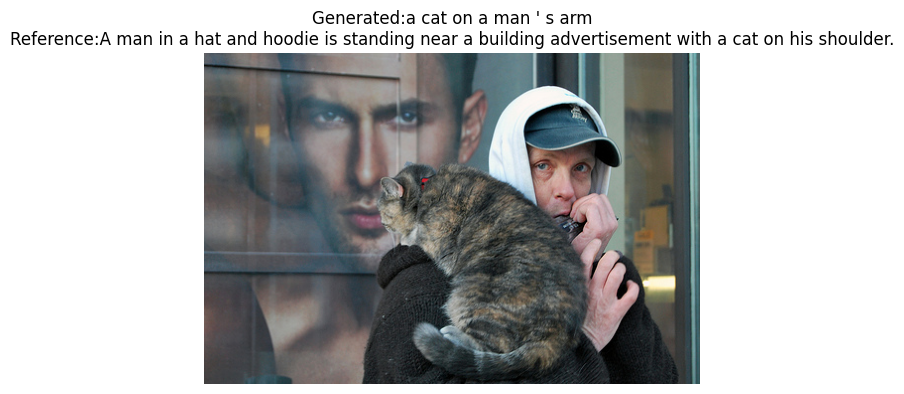

BLEU Score: 0.38943414376070784


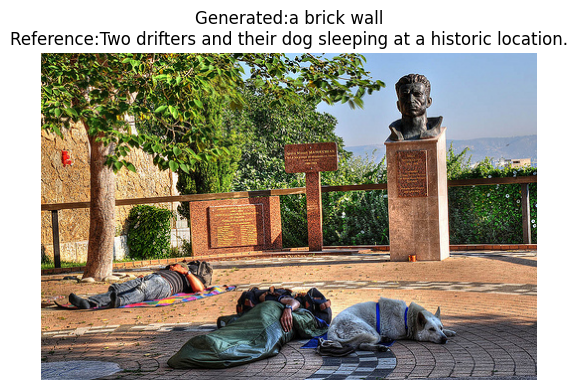

BLEU Score: 0.021375443555281443


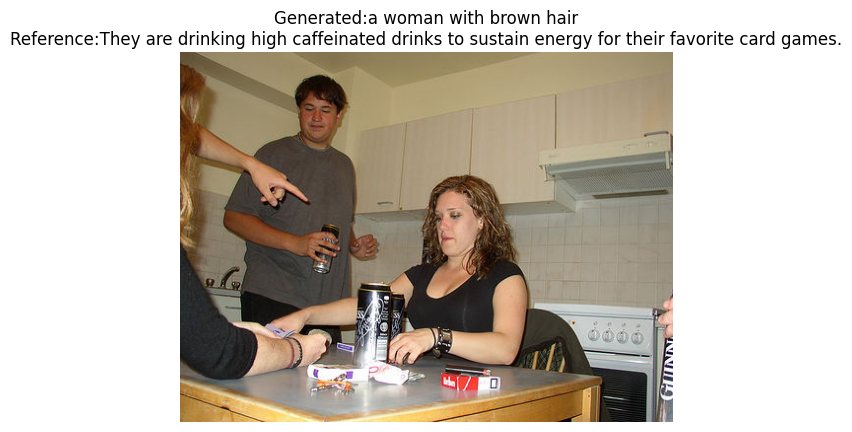

BLEU Score: 0.13015149926125663


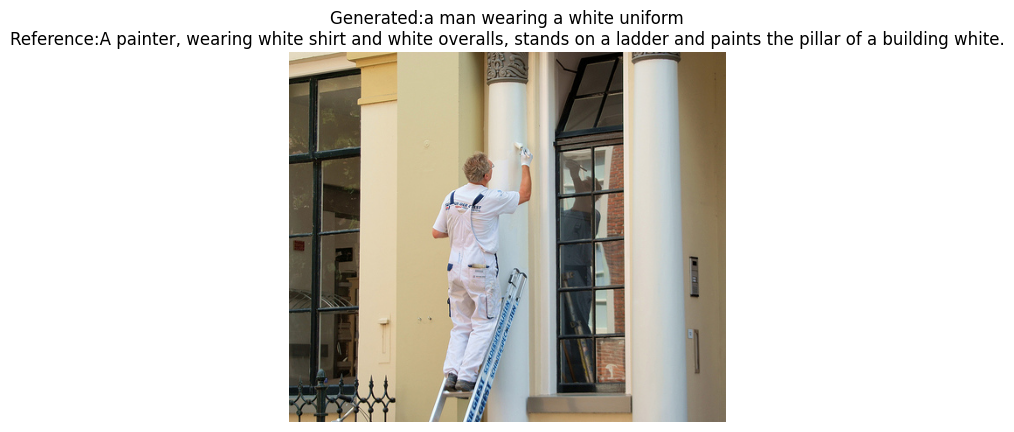

BLEU Score: 0.38791113894644796


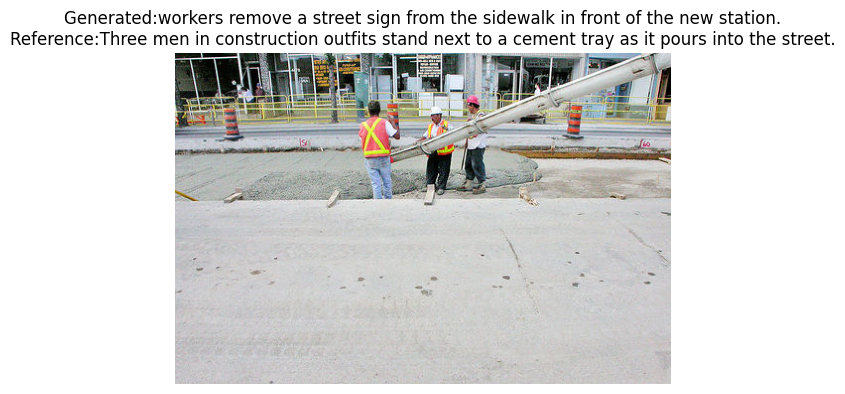

BLEU Score: 0.404725619143452


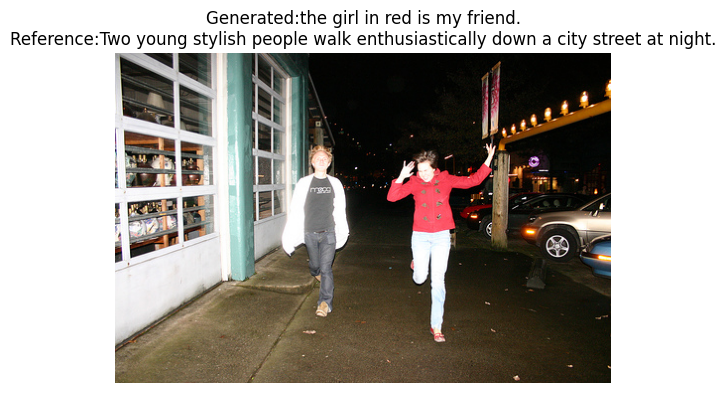

BLEU Score: 0.24109361271832833


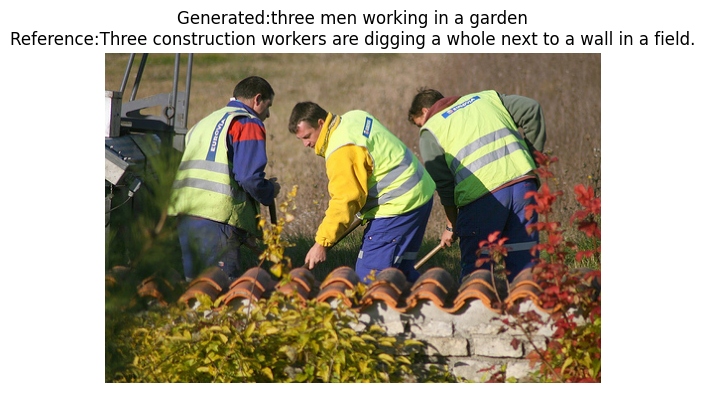

BLEU Score: 0.5991758181929989


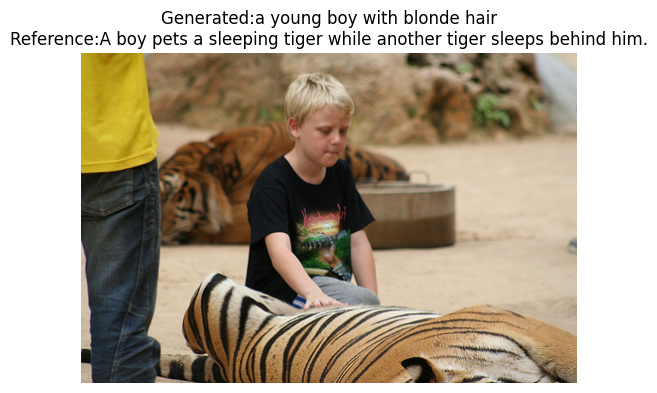

BLEU Score: 0.4417918226831577


In [27]:
# Assuming test_ds[0]['image'] contains the image data
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
smoothie = SmoothingFunction().method1  # Optional smoothing
for i in range(50,60):
    image = test_ds[i]['image']    
    inputs = processor(images=image, return_tensors="pt").to(device)
    pixel_values = inputs.pixel_values#.to(device)

    generated_ids = model.generate(pixel_values=pixel_values, max_length=50)
    generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
    #print(generated_caption)
    references = test_ds[i]['caption']
    bleu_score = sentence_bleu(references, generated_caption, smoothing_function=smoothie)
    plt.title('Generated:'+generated_caption+'\n'+'Reference:'+references[0])
    plt.imshow(image)
    plt.axis('off')  # Hide the axes for a cleaner view
    plt.show()
    print('BLEU Score:',bleu_score)


girl in field of flowers


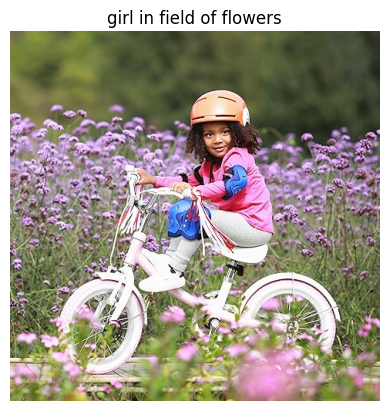

In [28]:
from PIL import Image
image = Image.open('./test_images/media._SL480_.jpeg')   
inputs = processor(images=image, return_tensors="pt").to(device)
pixel_values = inputs.pixel_values#.to(device)

generated_ids = model.generate(pixel_values=pixel_values, max_length=50)
generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
print(generated_caption)

plt.imshow(image)
plt.axis('off')  # Hide the axes for a cleaner view
plt.title(generated_caption)
plt.show()
